In [1]:
#import lightgbm
import random
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor
import time
from sklearn.metrics import make_scorer
t = time.strftime('%m%d-%H%M', time.localtime(time.time()))
import warnings
warnings.filterwarnings(action='ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(0) # Seed 고정

def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

 #점수 측정을 위한 코드  
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    
train_df = pd.read_csv(f'./submit/train_building1.csv')
test_df = pd.read_csv(f'./submit/test_building1.csv')
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature        2040 non-null   float64
 1   rainfall           2040 non-null   float64
 2   windspeed          2040 non-null   float64
 3   humidity           2040 non-null   float64
 4   power_consumption  2040 non-null   float64
 5   hour               2040 non-null   int64  
 6   day                2040 non-null   int64  
 7   month              2040 non-null   int64  
 8   week               2040 non-null   int64  
 9   holiday            2040 non-null   int64  
 10  CDH                2040 non-null   float64
 11  sin_time           2040 non-null   float64
 12  cos_time           2040 non-null   float64
 13  THI                2040 non-null   float64
 14  outlier            2040 non-null   int64  
 15  day_hour_mean      2040 non-null   float64
 16  day_hour_std       2040 

100%|██████████| 8/8 [01:06<00:00,  8.29s/it]


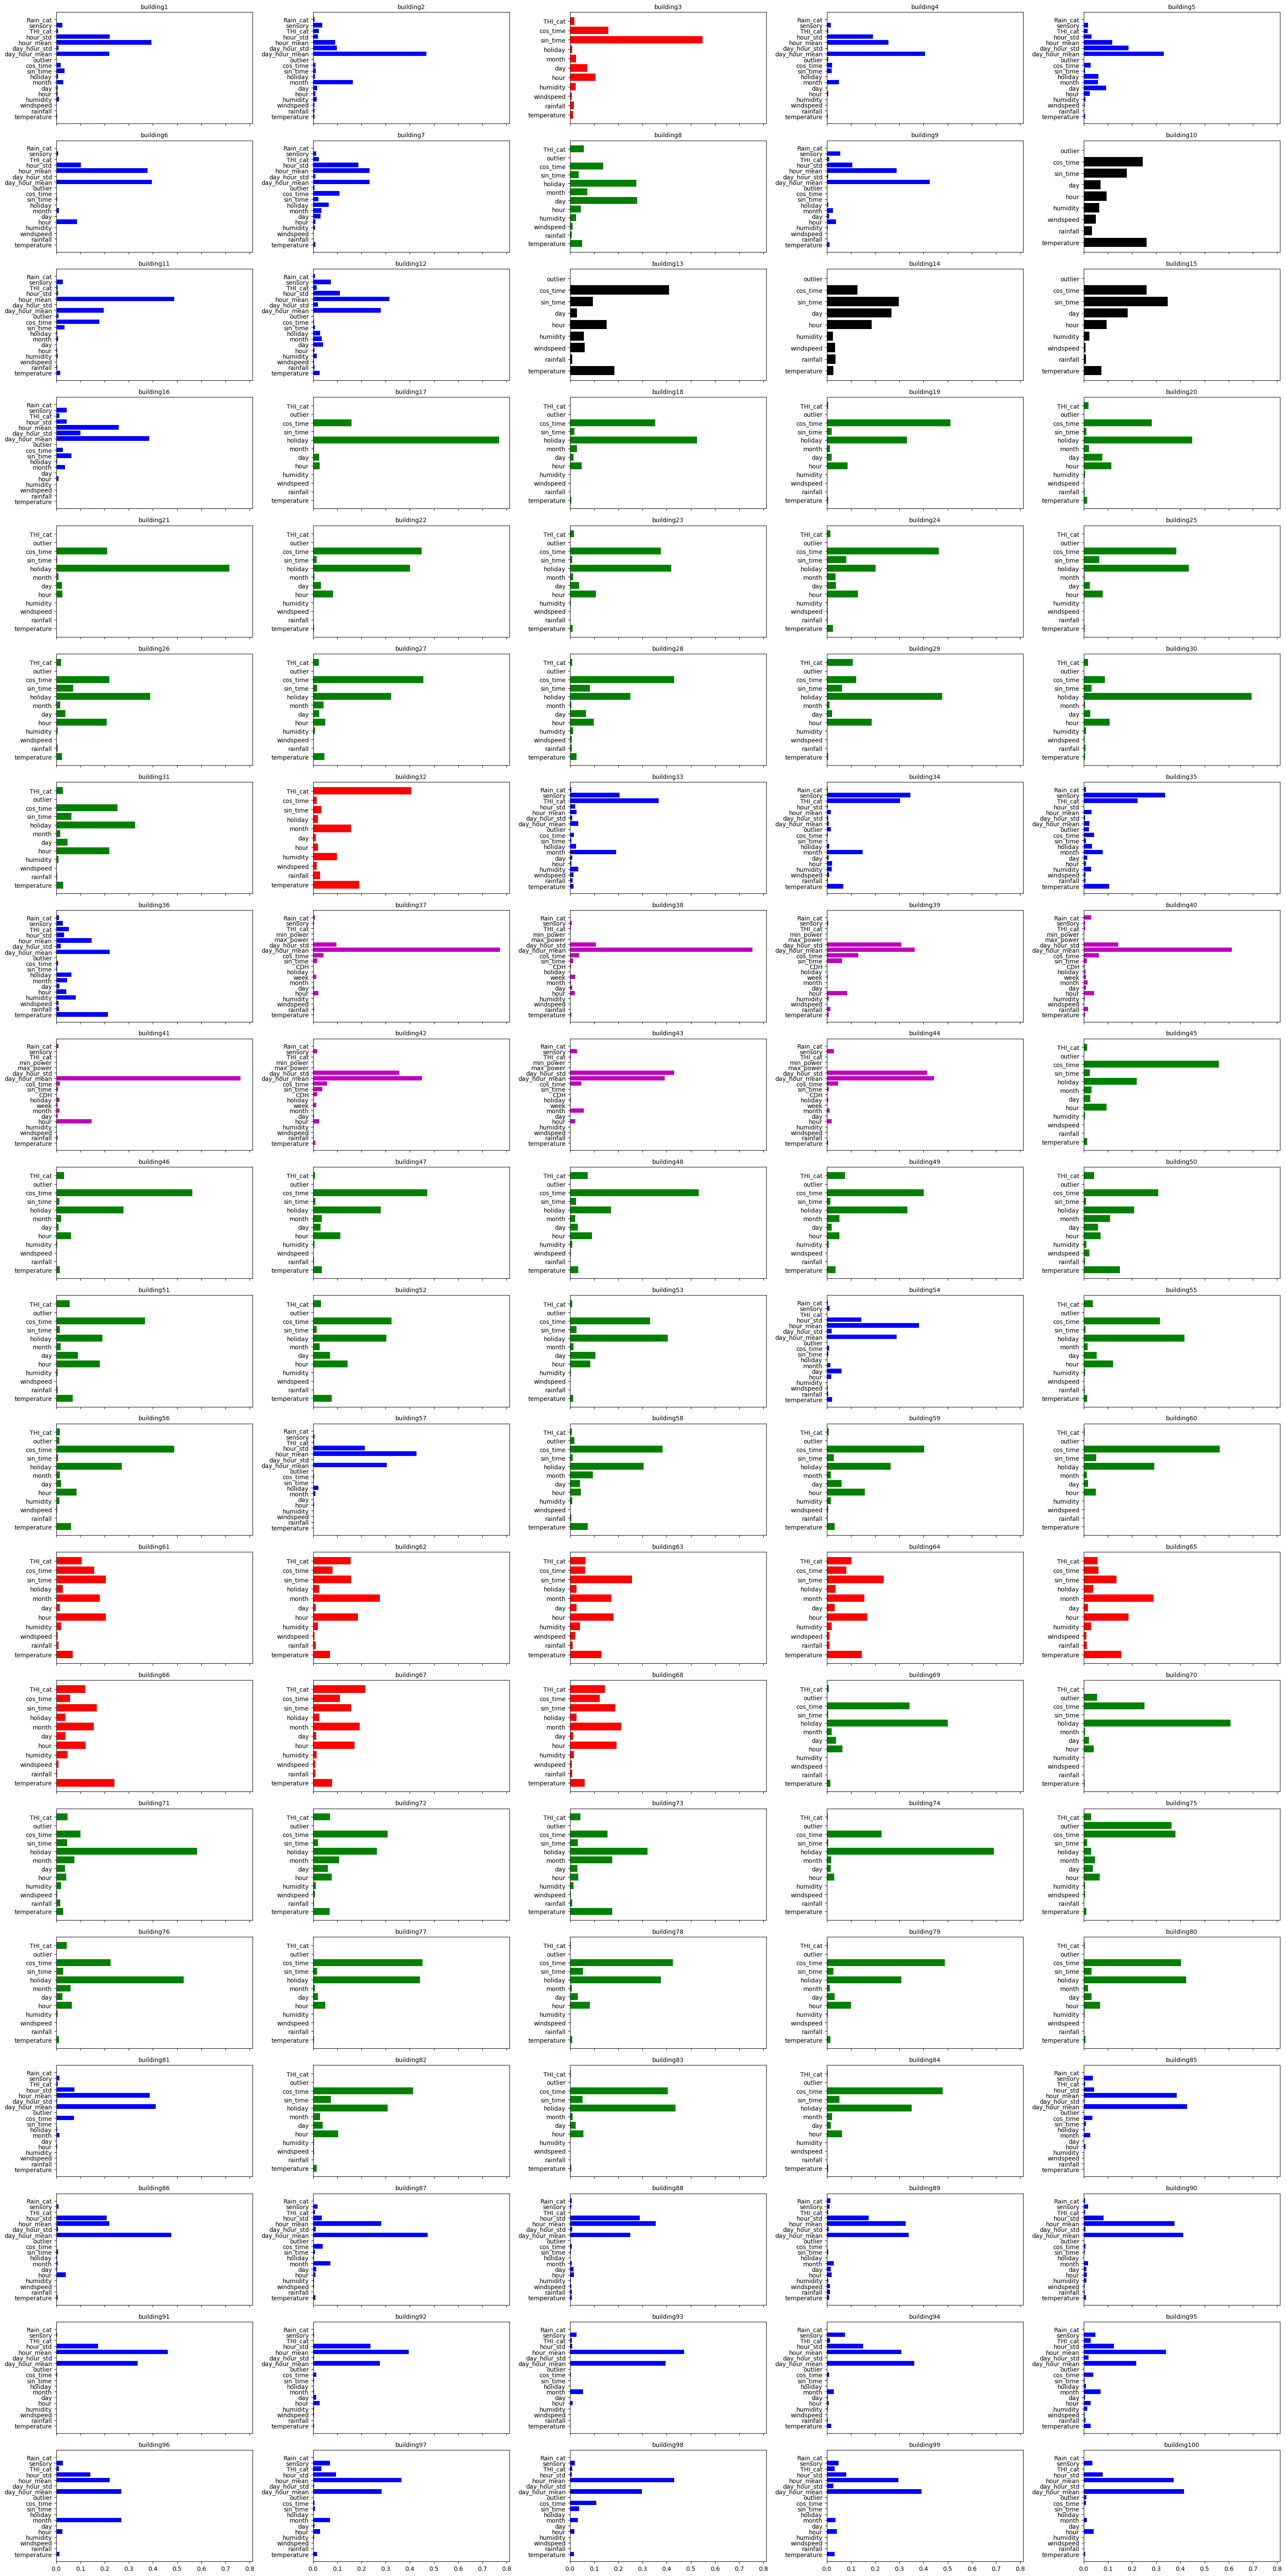

In [2]:
preds = [0 for _ in range(100)]
hyper = pd.read_csv('./parameters/hyperparameter_xgb_wsw0825-1730.csv').drop(columns=['Unnamed: 0'])

clusters = [
[3, 32, 61, 62, 63, 64, 65, 66, 67, 68],
[8, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 58, 59, 60, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84],
[1, 2, 4, 5, 6, 7, 9, 11, 12, 16, 33, 34, 35, 36, 54, 57, 81, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100],
[10, 13, 14, 15],
[37, 38, 39, 40, 41, 42, 43, 44]
]

drop_cols = [
[ 'week', 'THI', 'CDH', 'max_power', 'min_power','day_hour_mean','day_hour_std', 'hour_mean', 'hour_std','outlier','sensory','Rain_cat'],
[ 'week', 'THI', 'CDH', 'max_power', 'min_power' ,'day_hour_mean','day_hour_std','hour_mean', 'hour_std','sensory','Rain_cat'],
[ 'week', 'THI', 'CDH', 'max_power', 'min_power' ],
[ 'week','month','holiday', 'THI', 'CDH', 'day_hour_mean', 'day_hour_std','hour_mean', 'hour_std', 'max_power', 'min_power', 'THI_cat', 'sensory','Rain_cat'],
[ 'THI','hour_mean', 'hour_std', 'outlier']
]

color = ['red', 'green', 'blue', 'black', 'm']
fig, ax = plt.subplots(20, 5, figsize=(30, 60), sharex=True)
ax = ax.flatten()
for k in range(5):
    cluster = clusters[k]
    drop_col = drop_cols[k]
    c = color[k]
    for i in tqdm(cluster):
        train_df = pd.read_csv(f'./submit/train_building{i}.csv').drop(columns=drop_col)
        test_df = pd.read_csv(f'./submit/test_building{i}.csv').drop(columns=drop_col)
        pred_df = pd.DataFrame()   # 시드별 예측값을 담을 data frame
    ################################################

        feature_importances = []
    ################################################
        for seed in [0,1,2,3,4,5,6]: # 각 시드별 예측
            y_train = train_df['power_consumption']
            x_train = train_df.drop(columns=['power_consumption'])
            
            x_test = test_df

            xgb = XGBRegressor(seed = seed, tree_method="hist", gpu_id=0,          
                            n_estimators = hyper.at[i-1,'best_it'].astype('int64'), 
                            eta = hyper.at[i-1, 'eta'],
                            min_child_weight = hyper.at[i-1, 'min_child_weight'], max_depth = hyper.at[i-1, 'max_depth'],
                            colsample_bytree=hyper.at[i-1, 'colsample_bytree'], subsample=hyper.at[i-1, 'subsample'])

            if hyper.at[i-1,'alpha'] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
                xgb.set_params(**{'objective':weighted_mse(hyper.at[i-1,'alpha'])})

            xgb.fit(x_train, y_train)
            feature_importances.append(xgb.feature_importances_)
            y_pred = xgb.predict(x_test)
            pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기
        
        
        
        pred = pred_df.mean(axis=1)        # (i+1)번째 건물의 예측 =  (i+1)번째 건물의 각 시드별 예측 평균값
        preds[i-1]=pred
        average_feature_importances = np.mean(feature_importances, axis=0)
        ax[i-1].set_title(f'building{i}',fontsize = 10)
        ax[i-1].barh(x_train.columns, average_feature_importances, color = c)

plt.tight_layout()
plt.show()

In [3]:
np_preds = np.array(preds)
submit = np_preds.flatten()


In [4]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['answer'] = submit
submission.to_csv(f'./submission/submission_xgb_clust5.csv', index = False)

In [5]:
# preds = pd.Series(preds)

# fig, ax = plt.subplots(100, 1, figsize=(100,200), sharex = True)
# ax = ax.flatten()
# for i in range(100):
#     train_df = pd.read_csv(f'./split/train_building{i+1}.csv')
#     train_y = train_df['power_consumption']
#     test_y = submit[i*168:(i+1)*168]
#     ax[i].set_title(f'building_{i}')
#     ax[i].scatter(np.arange(2040) , train_y)
#     ax[i].scatter(np.arange(2040, 2040+168) , test_y)
#     ax[i].tick_params(axis='both', which='major', labelsize=6)
#     ax[i].tick_params(axis='both', which='minor', labelsize=4)
    
# plt.show()
# #plt.savefig(f'./Test_png/predict_xgb_wsw{t}.png')
